In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from astropy.io import fits 
import skimage
from skimage import exposure
from skimage import transform
from skimage import morphology
from scipy.signal import find_peaks

# 卫星轨迹的识别

In [2]:
def _Binarization(img: np.ndarray) -> np.ndarray:
    '二值化函数'
    #重新标度
    img1d = img.flatten()
    #背景计算
    mean,sigma= np.mean(img1d),np.std(img1d)
    minthresh,maxthresh= mean-3*sigma,mean +3*sigma
    while (mean-3*sigma>np.min(img1d) or mean+3*sigma<np.max(img1d)):
        img1d = img1d[(minthresh<img1d)&(maxthresh>img1d)]
        mean,sigma = np.mean(img1d),np.std(img1d)
        minthresh,maxthresh = mean-3*sigma,mean +3*sigma
    #二值化
    binary = np.where(img > mean+1.5*sigma, True, False)
    #清除小连通区域
    binary = np.uint8(morphology.remove_small_objects(binary,min_size=30,connectivity=1)) 

    #图像输出
    plt.figure()  
    plt.imshow(binary)
    plt.xlabel('The image after binarization')
    plt.gca().invert_yaxis()
    plt.show()
    
    return mean,sigma,binary

In [3]:
def _do_satellitetrail(flg: np.ndarray, img: np.ndarray) -> np.ndarray:
    """卫星轨迹标记
    """
    #二值化
    mean,sigma,binary = _Binarization(img)
    
    #霍夫变换
    length=int(img.shape[0]/15)
    gap=int(img.shape[0]/200)
    result = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=342, minLineLength=length, maxLineGap=gap)
    result = np.asarray(result)
    if result.shape==():
        print("no satellite trail")
        return flg
    
    n_result = len(result)    
    
    #绘制mask
    mask = np.zeros(img.shape)
    theta = []
    for i in range(n_result):
        #遍历每一条线段
        x1,y1,x2,y2 = result[i][0]
        theta.append(math.atan((y2-y1)/(x2-x1)))
        cv2.line(mask,(x1,y1),(x2,y2),1)
    mask = mask.astype('uint8')    
    
    #膨胀腐蚀，将轨迹中间的空隙补齐
    kernel = np.ones((3, 3), dtype=np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=3)
    mask = cv2.erode(mask, kernel, iterations=3)

    #边界值的处理,根据背景值筛选
    mask_edge = cv2.dilate(mask, kernel, iterations=5) - cv2.erode(mask, kernel, iterations=5)
    mask = mask&(~mask_edge)
    mask_edge[img*mask_edge<mean+3*sigma]=0    
    mask = mask|mask_edge
    mask = cv2.erode(mask, kernel, iterations=3)
    mask = cv2.dilate(mask, kernel, iterations=3)

    #输出flg
    ret = np.logical_or(flg,mask)
    flg = ret.astype(int)
    
    #图像输出
    plt.figure()  
    plt.imshow(mask)
    plt.xlabel('trail mask')
    plt.gca().invert_yaxis()
    plt.show()
    
    return theta,mean,flg

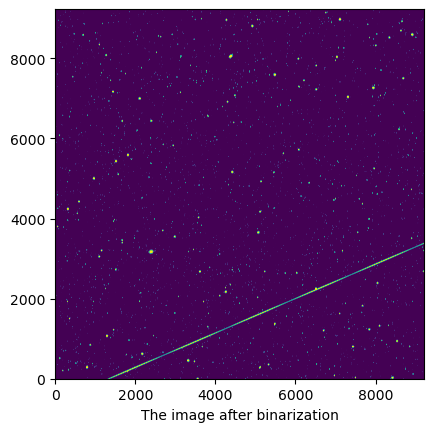

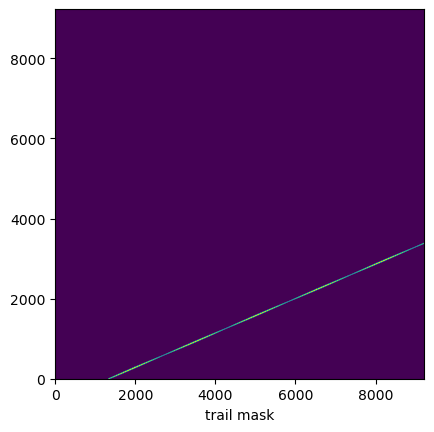

In [4]:
#读取图像
hdu=fits.open('image_trail.fits')
img=hdu[0].data
flg = fits.HDUList([fits.ImageHDU(header=hdu[0].header,data=np.zeros_like(img,dtype=np.uint16))])
#执行霍夫变换
theta,mean,flg[0].data = _do_satellitetrail(flg[0].data,img)
mask = flg[0].data

# 轨迹数据分析

In [5]:
#寻找轨迹角度
theta_deg = np.multiply(theta,180/math.pi)
theta_deg.sort()
theta_  = []
if theta_deg[-1] < theta_deg[0] + 2:
    theta_.append(np.mean(theta_deg))
#可能有多条轨迹
else :
    num = 0
    for i in range(np.size(theta_deg)):
        if theta_deg[i] > theta_[-1] + 2 :
            theta_.append(np.mean(theta_deg[num:i]))
            num = i
        theta_.append(np.mean(theta_deg[num:i]))

In [6]:
#图像旋转函数
def rotate_bound_white_bg(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH),borderValue= np.NaN)

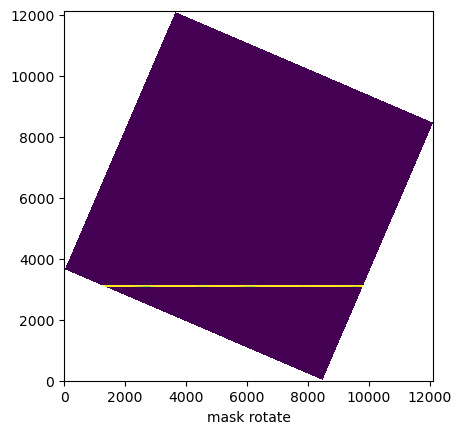

In [7]:
trail = mask * img
trail_rotate =  rotate_bound_white_bg(trail,-23.245)
#图像输出
plt.figure()  
plt.imshow(trail_rotate,vmin=0,vmax=0.2)
plt.xlabel('mask rotate')
plt.gca().invert_yaxis()
plt.show()

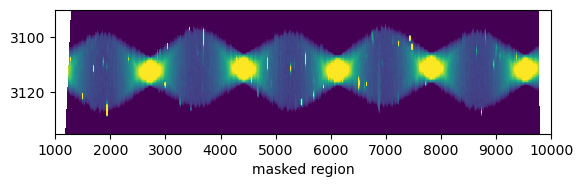

In [8]:
#图像细节
plt.figure()
plt.imshow(trail_rotate,vmin=0.4,vmax=1.2)
plt.gca().invert_yaxis()
plt.ylim(3090,3135)
plt.xlim(1000,10000)
plt.xlabel('masked region')
plt.gca().invert_yaxis()
ax = plt.gca()
ax.set_aspect(50)
plt.show()

In [9]:
def _Trailmedfilter(trail,mean):
    '轨迹修复'
    trail_filter = trail.copy()
    trail_filter[np.isnan(trail_filter)]=0
    pos = np.where(trail_filter!=0)
    xmax = trail.shape[0]
    ymax = trail.shape[1]
    #中值滤波,抹去轨迹中的星象
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-3):min(x+4, xmax+1),
                   max(0, y-3):min(y+4, ymax+1)]
        trail_filter[x, y] = np.median(clip)
    #三次滤波，更平滑
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-4):min(x+5, xmax+1),
                   max(0, y-4):min(y+5, ymax+1)]
        trail_filter[x, y] = np.median(clip)
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-4):min(x+5, xmax+1),
                   max(0, y-4):min(y+5, ymax+1)]
        trail_filter[x, y] = np.median(clip)

    return trail_filter

In [10]:
trail_rotate_filter = _Trailmedfilter(trail_rotate,mean)
trail_filter =  rotate_bound_white_bg(trail_rotate_filter,23.245)
#dx = int((np.shape(trail_filter)[0] - np.shape(img)[0])/2)
#dy = int((np.shape(trail_filter)[1] - np.shape(img)[1])/2)
#trail_filter2 = trail_filter[dx:np.shape(img)[0]+dx,dy:np.shape(img)[1]+dy]

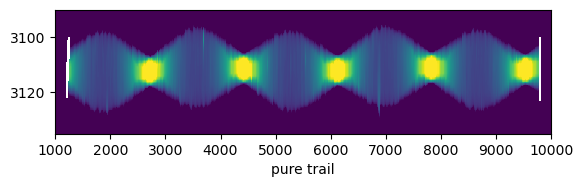

In [11]:
#图像细节
plt.figure()
plt.imshow(trail_rotate_filter,vmin=0.4,vmax=1.2)
plt.gca().invert_yaxis()
plt.ylim(3090,3135)
plt.xlim(1000,10000)
plt.xlabel('pure trail')
plt.gca().invert_yaxis()
ax = plt.gca()
ax.set_aspect(50)
plt.show()

# 轨迹的修正

In [12]:
def _Trailinpaint(img,mask,mean):
    '轨迹修复'
    trail = img*mask
    pos = np.where(mask!=0)
    xmax = img.shape[0]
    ymax = img.shape[1]
    #中值滤波,抹去轨迹中的星象
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-2):min(x+3, xmax+1),
                   max(0, y-2):min(y+3, ymax+1)]
        trail[x, y] = np.median(clip)
    #二次滤波，更平滑
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-2):min(x+3, xmax+1),
                   max(0, y-2):min(y+3, ymax+1)]
        trail[x, y] = np.median(clip)
    for i in range(len(pos[0])):
        x = pos[0][i]
        y = pos[1][i]
        clip = trail[max(0, x-3):min(x+4, xmax+1),
                   max(0, y-3):min(y+4, ymax+1)]
        trail[x, y] = np.median(clip)
    
    inpainted = img - trail +mean*mask
    return inpainted,trail

In [13]:
inpainted,trail = _Trailinpaint(img,mask,mean)

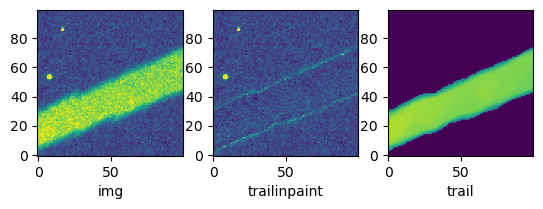

In [14]:
#plot
plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img[100:200,1600:1700],vmax=0.75,vmin=0)
plt.xlabel("img")
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
plt.imshow(inpainted[100:200,1600:1700],vmax=0.75,vmin=0)
plt.xlabel("trailinpaint")
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.imshow(trail[100:200,1600:1700],vmax=0.75,vmin=0)
plt.xlabel("trail")
plt.gca().invert_yaxis()
plt.show()

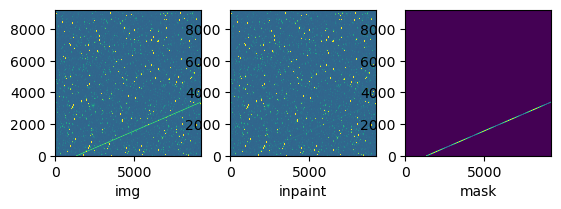

In [15]:
#plot
plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img,vmax=0.5,vmin=0)
plt.xlabel("img")
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
plt.imshow(inpainted,vmax=0.5,vmin=0)
plt.xlabel("inpaint")
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.imshow(mask,vmax=0.5,vmin=0)
plt.xlabel("mask")
plt.gca().invert_yaxis()
plt.savefig('result.png',dpi=800)

In [16]:
output=fits.PrimaryHDU(mask)
outHDU=fits.HDUList([output])
outHDU.writeto('image_trail-mask.fits')

In [17]:
output=fits.PrimaryHDU(inpainted)
outHDU=fits.HDUList([output])
outHDU.writeto('image_trail-inpaint.fits')